# Time Series for UK

In [22]:
import re, io
import os, json
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import performance_metrics
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from time_series import *
from pandas._libs.tslibs import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
DATA_DIR = os.path.join("..", "data/cs-train")

plt.style.use('seaborn')
%matplotlib inline

In [2]:
df = pd.DataFrame()

data_filenames = [f for f in os.listdir(DATA_DIR) if os.path.isfile(os.path.join(DATA_DIR, f))]
data_filenames = sorted(data_filenames)

for filename in data_filenames:
    invoice_filename = os.path.join(DATA_DIR, filename)
    invoice_df = pd.read_json(invoice_filename)
    
    # Rename column names where applicable
    invoice_df = invoice_df.rename(columns={
        'total_price': 'price',
        'StreamID': 'stream_id',
        'TimesViewed': 'times_viewed'
    })
    
    df = df.append(invoice_df)


# Set country to a categorical type
df['country'] = df['country'].astype('category')
df['invoice'] = df['invoice'].astype('category')
df['customer_id'] = df['customer_id'].astype('category')
df['stream_id'] = df['stream_id'].astype('category')
# Drop - price error from database
df=df[df["price"]>0]
   
df.head()

country customer_id invoice  price stream_id  times_viewed  year  \
0  United Kingdom     13085.0  489434   6.95     85048            12  2017   
1  United Kingdom         NaN  489597   8.65     22130             1  2017   
2  United Kingdom         NaN  489597   1.70     22132             6  2017   
3  United Kingdom         NaN  489597   1.70     22133             4  2017   
4  United Kingdom         NaN  489597   0.87     22134             1  2017   

   month  day  
0     11   28  
1     11   28  
2     11   28  
3     11   28  
4     11   28

In [3]:
# Database for each country
df_UK = df[df['country']=='United Kingdom']

## United Kingdom

In [4]:
df_day_UK = df_UK.groupby(['year', 'month', 'day']).agg({'times_viewed':'sum', 'price':'sum',
                                        'country':'first',}).reset_index()
df_day_UK = create_date_col(df_day_UK)
df_day_UK = df_day_UK[df_day_UK['price']<=20000]
df_day_UK.head()

year  month  day  times_viewed     price         country       Date
0  2017     11   28         12893  13281.12  United Kingdom 2017-11-28
1  2017     11   29         13601  13222.97  United Kingdom 2017-11-29
2  2017     11   30         15162  12941.50  United Kingdom 2017-11-30
3  2017     12    1         11633   9163.07  United Kingdom 2017-12-01
4  2017     12    2          3098   1263.28  United Kingdom 2017-12-02

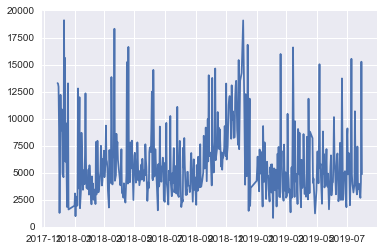

In [5]:
ts_UK = df_day_UK[['price', 'Date']].set_index('Date') # Set Date as index
ts_UK = ts_UK['price']
plt.plot(ts_UK);

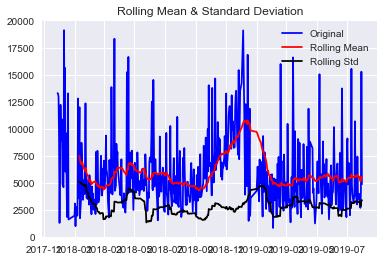

Results of Dickey-Fuller Test:
Test Statistic                  -4.880806
p-value                          0.000038
#Lags Used                       6.000000
Number of Observations Used    468.000000
Critical Value (1%)             -3.444400
Critical Value (5%)             -2.867736
Critical Value (10%)            -2.570070
dtype: float64


In [6]:
test_stationarity(ts_UK);

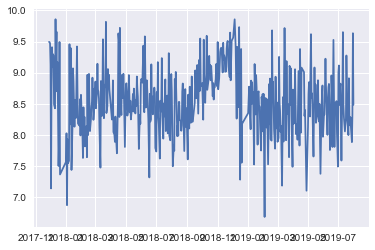

In [7]:
ts_log_UK = np.log(ts_UK)
plt.plot(ts_log_UK);

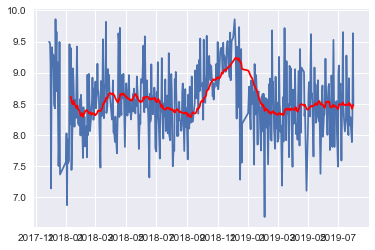

In [8]:
moving_avg_UK = ts_log_UK.rolling(30).mean()
plt.plot(ts_log_UK)
plt.plot(moving_avg_UK, color='red');

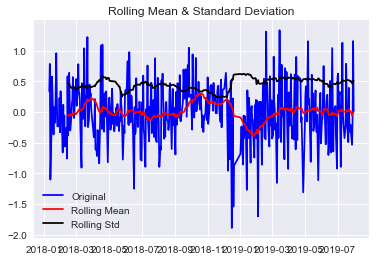

Results of Dickey-Fuller Test:
Test Statistic                -6.521573e+00
p-value                        1.039020e-08
#Lags Used                     5.000000e+00
Number of Observations Used    4.400000e+02
Critical Value (1%)           -3.445300e+00
Critical Value (5%)           -2.868131e+00
Critical Value (10%)          -2.570281e+00
dtype: float64


In [9]:
ts_log_moving_avg_diff_UK = ts_log_UK - moving_avg_UK

ts_log_moving_avg_diff_UK.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff_UK)

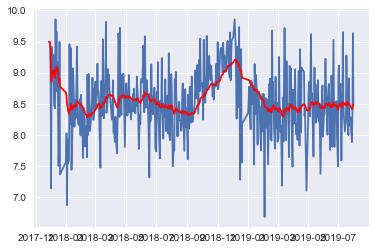

In [10]:
expwighted_avg_UK = ts_log_UK.ewm(halflife=12).mean()
plt.plot(ts_log_UK)
plt.plot(expwighted_avg_UK, color='red');

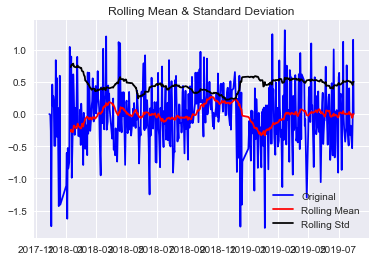

Results of Dickey-Fuller Test:
Test Statistic                -6.997642e+00
p-value                        7.461980e-10
#Lags Used                     5.000000e+00
Number of Observations Used    4.690000e+02
Critical Value (1%)           -3.444370e+00
Critical Value (5%)           -2.867722e+00
Critical Value (10%)          -2.570063e+00
dtype: float64


In [11]:
ts_log_ewma_diff_UK = ts_log_UK - expwighted_avg_UK
test_stationarity(ts_log_ewma_diff_UK)

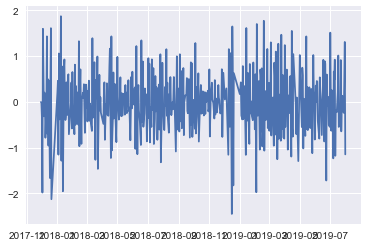

In [12]:
ts_log_diff_UK = ts_log_UK - ts_log_UK.shift()
plt.plot(ts_log_diff_UK);

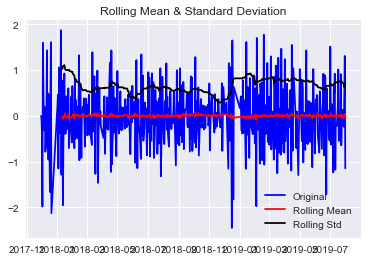

Results of Dickey-Fuller Test:
Test Statistic                -8.828334e+00
p-value                        1.798006e-14
#Lags Used                     1.600000e+01
Number of Observations Used    4.570000e+02
Critical Value (1%)           -3.444740e+00
Critical Value (5%)           -2.867885e+00
Critical Value (10%)          -2.570150e+00
dtype: float64


In [13]:
ts_log_diff_UK.dropna(inplace=True)
test_stationarity(ts_log_diff_UK);

In [17]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf

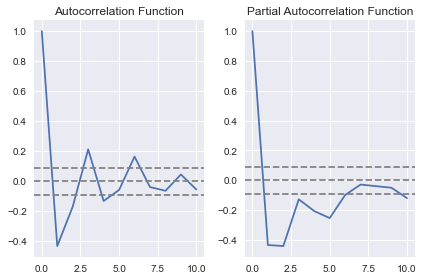

In [23]:
lag_acf = acf(ts_log_diff_UK, nlags=10)
lag_pacf = pacf(ts_log_diff_UK, nlags=10, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff_UK)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [24]:
ts_log_UK = np.log(ts_UK)
ts_log_diff_UK = ts_log_UK - ts_log_UK.shift()
ts_log_diff_UK.dropna(inplace=True)

In [25]:
from statsmodels.tsa.arima_model import ARIMA

/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'RSS: nan')

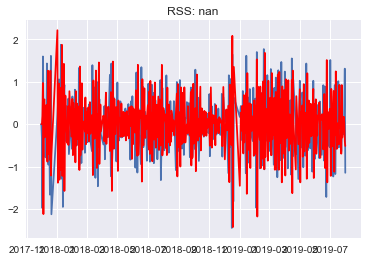

In [26]:
model_UK = ARIMA(ts_log_diff_UK, order=(1, 1, 0))  
results_AR_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_AR_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR_UK.fittedvalues-ts_log_diff_UK)**2))

/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'RSS: 126.2552')

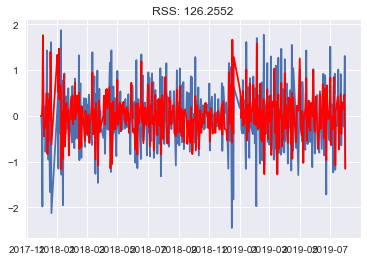

In [27]:
model_UK = ARIMA(ts_log_UK, order=(0, 1, 1))  
results_MA_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_MA_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA_UK.fittedvalues-ts_log_diff_UK)**2))

/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/akademik/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


Text(0.5, 1.0, 'RSS: 125.0154')

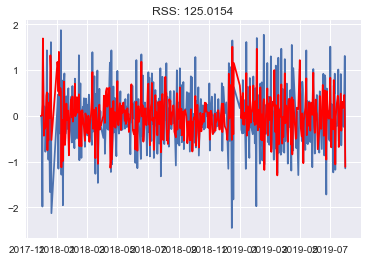

In [28]:
model_UK = ARIMA(ts_log_UK, order=(2, 1, 1))  
results_ARIMA_UK = model_UK.fit(disp=-1)  
plt.plot(ts_log_diff_UK)
plt.plot(results_ARIMA_UK.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_UK.fittedvalues-ts_log_diff_UK)**2))

Text(0.5, 1.0, 'RMSE: 4487542.9018')

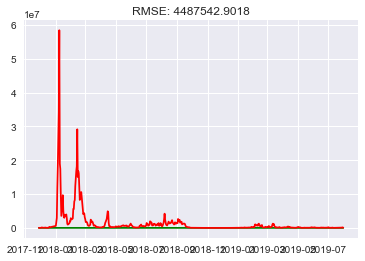

In [29]:
predictions_ARIMA_diff_UK = pd.Series(results_ARIMA_UK.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum_UK = predictions_ARIMA_diff_UK.cumsum()
predictions_ARIMA_log_UK = pd.Series(ts_log_UK.iloc[0], index=ts_log_UK.index)
predictions_ARIMA_log_UK = predictions_ARIMA_log_UK.add(predictions_ARIMA_diff_cumsum_UK,fill_value=0)
predictions_ARIMA_UK = np.exp(predictions_ARIMA_log_UK)
plt.plot(ts_UK, color='green')
plt.plot(predictions_ARIMA_UK, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_UK-ts_UK)**2)/len(ts_UK)))

In [30]:
ts_UK=df_day_UK[['price', 'Date']].set_index('Date')
ts_UK=ts_UK.asfreq(freq='1D')
ts_UK['price'].interpolate(inplace = True)
ts_UK

price
Date                 
2017-11-28  13281.120
2017-11-29  13222.970
2017-11-30  12941.500
2017-12-01   9163.070
2017-12-02   1263.280
...               ...
2019-07-27   3017.455
2019-07-28   2656.700
2019-07-29   4124.820
2019-07-30  15260.120
2019-07-31   4844.040

[611 rows x 1 columns]

In [31]:
m_UK = Prophet()
ts_UK = make_continuous(df_day_UK)
df_UK = pd.DataFrame()
df_UK['ds'] = ts_UK.index
df_UK['y'] = ts_UK.price.values
m_UK.fit(df_UK)
future_UK = m_UK.make_future_dataframe(periods=30)
future_UK.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds
636 2019-08-26
637 2019-08-27
638 2019-08-28
639 2019-08-29
640 2019-08-30

In [32]:
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m_UK, initial='500 days', period='150 days', horizon = '100 days')
df_cv.head()


INFO:fbprophet:Making 1 forecasts with cutoffs between 2019-04-22 00:00:00 and 2019-04-22 00:00:00


ds         yhat   yhat_lower    yhat_upper            y     cutoff
0 2019-04-23  6140.970196  2035.238813  10254.947924  8178.900000 2019-04-22
1 2019-04-24  5417.323851  1365.184994   9146.719556  4042.970000 2019-04-22
2 2019-04-25  6474.697586  2387.726495  10129.854558  4442.670000 2019-04-22
3 2019-04-26  5417.060630  1712.092148   9287.094506  3367.826667 2019-04-22
4 2019-04-27  4335.777664   489.133888   8619.352576  2292.983333 2019-04-22

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds   trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2017-11-28  8032.0      5646.0     12424.0       8032.0       8032.0   
1   2017-11-29  7941.0      4673.0     11629.0       7941.0       7941.0   
2   2017-11-30  7850.0      5330.0     12364.0       7850.0       7850.0   
3   2017-12-01  7759.0      4128.0     10991.0       7759.0       7759.0   
4   2017-12-02  7668.0      3365.0      9883.0       7668.0       7668.0   
..         ...     ...         ...         ...          ...          ...   
706 2019-11-04  5682.0      1882.0     11377.0       1966.0       8968.0   
707 2019-11-05  5686.0      1945.0     11391.0       1904.0       9031.0   
708 2019-11-06  5689.0       644.0     11067.0       1839.0       9081.0   
709 2019-11-07  5692.0      1639.0     11664.0       1772.0       9135.0   
710 2019-11-08  5695.0       720.0     10518.0       1723.0       9188.0   

     additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0             946.0                 946.0                 946.0   946.0   
1             156.0                 156.0                 156.0   156.0   
2             959.0                 959.0                 959.0   959.0   
3              -8.0                  -8.0                  -8.0    -8.0   
4           -1079.0               -1079.0               -1079.0 -1079.0   
..              ...                   ...                   ...     ...   
706          1029.0                1029.0                1029.0  1029.0   
707           946.0                 946.0                 946.0   946.0   
708           156.0                 156.0                 156.0   156.0   
709           959.0                 959.0                 959.0   959.0   
710            -8.0                  -8.0                  -8.0    -8.0   

     weekly_lower  weekly_upper  multiplicative_terms  \
0           946.0         946.0                   0.0   
1           156.0         156.0                   0.0   
2           959.0         959.0                   0.0   
3            -8.0          -8.0                   0.0   
4         -1079.0       -1079.0                   0.0   
..            ...           ...                   ...   
706        1029.0        1029.0                   0.0   
707         946.0         946.0                   0.0   
708         156.0         156.0                   0.0   
709         959.0         959.0                   0.0   
710          -8.0          -8.0                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper    yhat  
0                           0.0                         0.0  8978.0  
1                           0.0                         0.0  8097.0  
2                           0.0                         0.0  8809.0  
3                           0.0                         0.0  7751.0  
4                           0.0                         0.0  6589.0  
..                          ...                         ...     ...  
706                         0.0                         0.0  6711.0  
707                         0.0                         0.0  6631.0  
708                         0.0                         0.0  5845.0  
709                         0.0                         0.0  6651.0  
710                         0.0                         0.0  5687.0  

[711 rows x 16 columns]

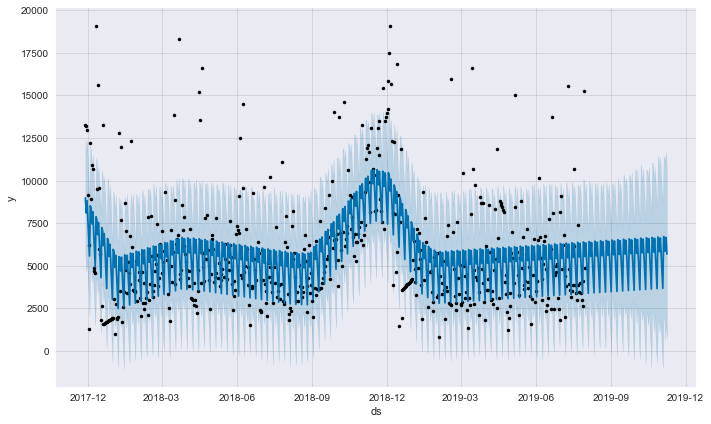

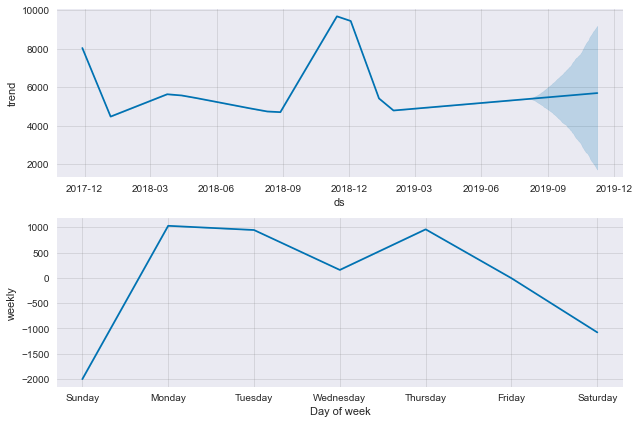

In [33]:
prophet_forecast(df_day_UK, 100)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


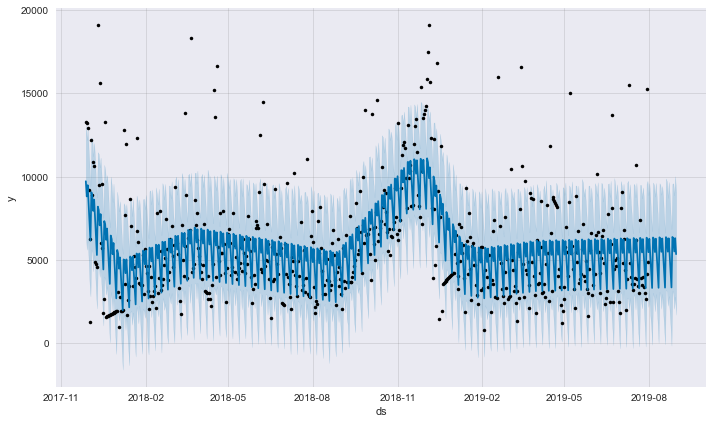

In [34]:
ts_UK = make_continuous(df_day_UK)
df_UK = pd.DataFrame()
df_UK['ds'] = ts_UK.index
df_UK['y'] = ts_UK.price.values
m2 = Prophet(changepoint_prior_scale=0.8)
m_UK = m2.fit(df_UK)
future = m2.make_future_dataframe(periods = 30)
forecast = m_UK.predict(future)
fig = m2.plot(forecast)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds   trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2017-11-28  8032.0      5637.0     12337.0       8032.0       8032.0   
1   2017-11-29  7941.0      4898.0     11542.0       7941.0       7941.0   
2   2017-11-30  7850.0      5268.0     12307.0       7850.0       7850.0   
3   2017-12-01  7759.0      4180.0     11210.0       7759.0       7759.0   
4   2017-12-02  7668.0      3097.0      9843.0       7668.0       7668.0   
..         ...     ...         ...         ...          ...          ...   
706 2019-11-04  5682.0      1854.0     11428.0       2270.0       8924.0   
707 2019-11-05  5686.0      2007.0     11290.0       2213.0       8990.0   
708 2019-11-06  5689.0       860.0     10821.0       2157.0       9038.0   
709 2019-11-07  5692.0      1527.0     11600.0       2103.0       9097.0   
710 2019-11-08  5695.0       550.0     10576.0       2070.0       9155.0   

     additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0             946.0                 946.0                 946.0   946.0   
1             156.0                 156.0                 156.0   156.0   
2             959.0                 959.0                 959.0   959.0   
3              -8.0                  -8.0                  -8.0    -8.0   
4           -1079.0               -1079.0               -1079.0 -1079.0   
..              ...                   ...                   ...     ...   
706          1029.0                1029.0                1029.0  1029.0   
707           946.0                 946.0                 946.0   946.0   
708           156.0                 156.0                 156.0   156.0   
709           959.0                 959.0                 959.0   959.0   
710            -8.0                  -8.0                  -8.0    -8.0   

     weekly_lower  weekly_upper  multiplicative_terms  \
0           946.0         946.0                   0.0   
1           156.0         156.0                   0.0   
2           959.0         959.0                   0.0   
3            -8.0          -8.0                   0.0   
4         -1079.0       -1079.0                   0.0   
..            ...           ...                   ...   
706        1029.0        1029.0                   0.0   
707         946.0         946.0                   0.0   
708         156.0         156.0                   0.0   
709         959.0         959.0                   0.0   
710          -8.0          -8.0                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper    yhat  
0                           0.0                         0.0  8978.0  
1                           0.0                         0.0  8097.0  
2                           0.0                         0.0  8809.0  
3                           0.0                         0.0  7751.0  
4                           0.0                         0.0  6589.0  
..                          ...                         ...     ...  
706                         0.0                         0.0  6711.0  
707                         0.0                         0.0  6631.0  
708                         0.0                         0.0  5845.0  
709                         0.0                         0.0  6651.0  
710                         0.0                         0.0  5687.0  

[711 rows x 16 columns]

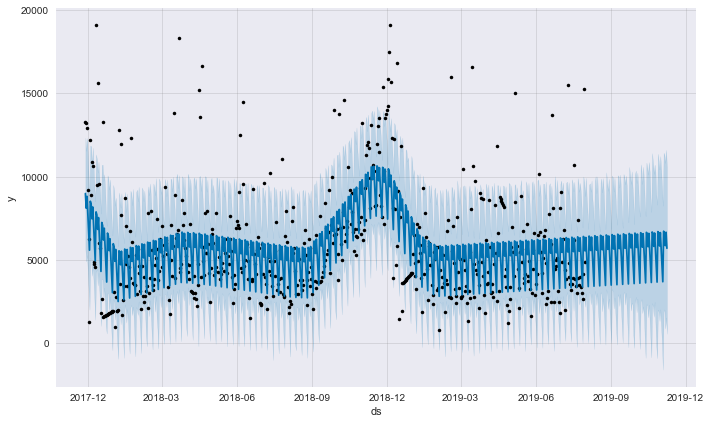

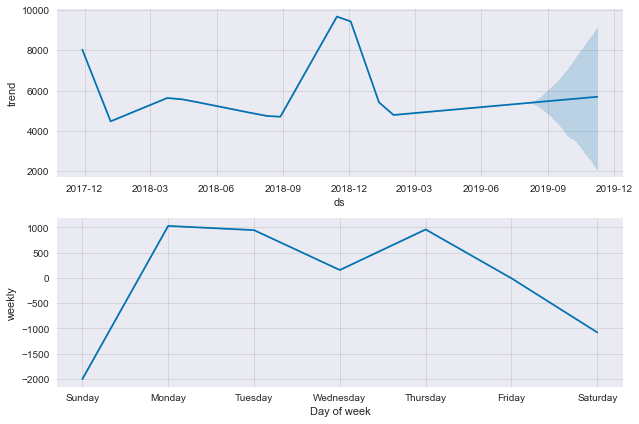

In [35]:
prophet_forecast(df_day_UK, 100, 0.5)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds   trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2017-11-28  8775.0      6337.0     12795.0       8775.0       8775.0   
1   2017-11-29  8651.0      5655.0     12113.0       8651.0       8651.0   
2   2017-11-30  8526.0      6344.0     12829.0       8526.0       8526.0   
3   2017-12-01  8402.0      5007.0     11695.0       8402.0       8402.0   
4   2017-12-02  8278.0      3734.0     10520.0       8278.0       8278.0   
..         ...     ...         ...         ...          ...          ...   
706 2019-11-04  5444.0       484.0     12245.0        503.0       9900.0   
707 2019-11-05  5446.0       547.0     12167.0        414.0      10011.0   
708 2019-11-06  5447.0      -297.0     11591.0        315.0      10104.0   
709 2019-11-07  5449.0       288.0     12279.0        173.0      10195.0   
710 2019-11-08  5450.0      -844.0     11724.0         32.0      10281.0   

     additive_terms  additive_terms_lower  additive_terms_upper  weekly  \
0             942.0                 942.0                 942.0   942.0   
1             154.0                 154.0                 154.0   154.0   
2             957.0                 957.0                 957.0   957.0   
3              -8.0                  -8.0                  -8.0    -8.0   
4           -1077.0               -1077.0               -1077.0 -1077.0   
..              ...                   ...                   ...     ...   
706          1032.0                1032.0                1032.0  1032.0   
707           942.0                 942.0                 942.0   942.0   
708           154.0                 154.0                 154.0   154.0   
709           957.0                 957.0                 957.0   957.0   
710            -8.0                  -8.0                  -8.0    -8.0   

     weekly_lower  weekly_upper  multiplicative_terms  \
0           942.0         942.0                   0.0   
1           154.0         154.0                   0.0   
2           957.0         957.0                   0.0   
3            -8.0          -8.0                   0.0   
4         -1077.0       -1077.0                   0.0   
..            ...           ...                   ...   
706        1032.0        1032.0                   0.0   
707         942.0         942.0                   0.0   
708         154.0         154.0                   0.0   
709         957.0         957.0                   0.0   
710          -8.0          -8.0                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper    yhat  
0                           0.0                         0.0  9716.0  
1                           0.0                         0.0  8805.0  
2                           0.0                         0.0  9484.0  
3                           0.0                         0.0  8395.0  
4                           0.0                         0.0  7201.0  
..                          ...                         ...     ...  
706                         0.0                         0.0  6476.0  
707                         0.0                         0.0  6387.0  
708                         0.0                         0.0  5601.0  
709                         0.0                         0.0  6406.0  
710                         0.0                         0.0  5443.0  

[711 rows x 16 columns]

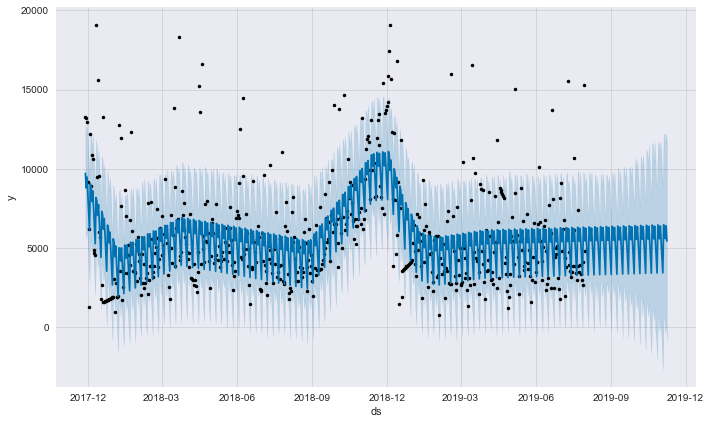

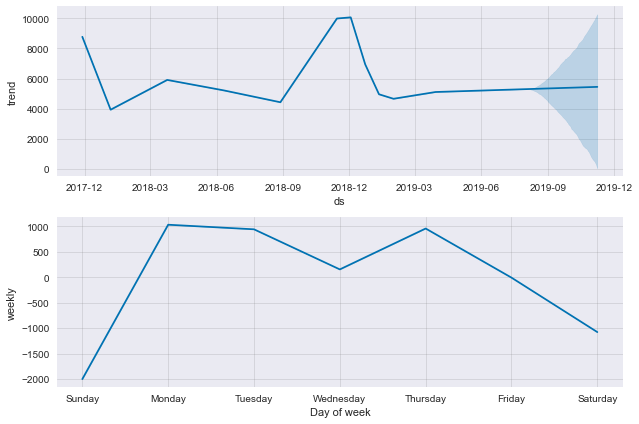

In [36]:
prophet_forecast(df_day_UK, 100, 0.8)